Score на Kaggle: 0.98937
Ник: Suleyman Sagitov

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

Mounted at /content/gdrive/


In [ ]:
train_dir = r'train/simpsons_dataset'
test_dir = r'testset/testset'

АУГМЕНТАЦИЯ

In [ ]:
import os

minorty_classes = {}
treshold = 500

for class_path in os.listdir(train_dir):
    class_path = os.sep.join([train_dir, class_path])
    if len(os.listdir(class_path)) < treshold:
        minorty_classes[class_path] = len(os.listdir(class_path))

In [ ]:
minorty_classes

{'train/simpsons_dataset/rainier_wolfcastle': 45,
 'train/simpsons_dataset/agnes_skinner': 42,
 'train/simpsons_dataset/waylon_smithers': 181,
 'train/simpsons_dataset/disco_stu': 8,
 'train/simpsons_dataset/cletus_spuckler': 47,
 'train/simpsons_dataset/ralph_wiggum': 89,
 'train/simpsons_dataset/edna_krabappel': 457,
 'train/simpsons_dataset/troy_mcclure': 8,
 'train/simpsons_dataset/fat_tony': 27,
 'train/simpsons_dataset/mayor_quimby': 246,
 'train/simpsons_dataset/snake_jailbird': 55,
 'train/simpsons_dataset/nelson_muntz': 358,
 'train/simpsons_dataset/maggie_simpson': 128,
 'train/simpsons_dataset/professor_john_frink': 65,
 'train/simpsons_dataset/lenny_leonard': 310,
 'train/simpsons_dataset/patty_bouvier': 72,
 'train/simpsons_dataset/lionel_hutz': 3,
 'train/simpsons_dataset/selma_bouvier': 103,
 'train/simpsons_dataset/comic_book_guy': 469,
 'train/simpsons_dataset/groundskeeper_willie': 121,
 'train/simpsons_dataset/martin_prince': 71,
 'train/simpsons_dataset/gil': 27,
 '

In [ ]:
import torch
from torchvision.transforms import v2


transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.8),
    v2.RandomVerticalFlip(p=0.8),
    v2.ColorJitter(),
    v2.RandomGrayscale(p=0.4),
    v2.RandomInvert(p=0.2),
])

In [ ]:
import random
from PIL import Image

for class_path in minorty_classes.keys():
    difference = treshold - minorty_classes[class_path]
    for i in range(difference):
        image_path = random.choice(os.listdir(class_path))
        image_path = os.sep.join([class_path, image_path])
        with Image.open(image_path) as image:
            image = transforms(image)
            image.save(os.sep.join([class_path, 'new_image' + f'{i}' + '.jpeg']))

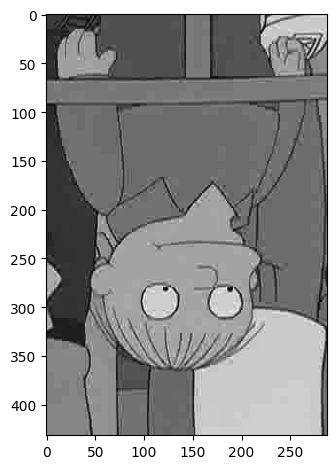

In [ ]:
from skimage import io

class_path = random.choice(list(minorty_classes.keys()))
difference = treshold - minorty_classes[class_path]
i = random.choice(range(difference))
image_path = os.sep.join([class_path, 'new_image' + f'{i}' + '.jpeg'])
io.imshow(image_path)

ПОДГОТОВКА ДАТАСЕТА

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

ОБЧЕНИЕ МОДЕЛИ

In [ ]:
from torchvision import models

model = models.resnet18(pretrained=True)

In [ ]:
num_features = 512
model.fc = nn.Linear(num_features, 42)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(params=[
            {"params": model.fc.parameters()},
            {"params": model.layer1.parameters(), "lr": 1e-5,},
            {"params": model.layer2.parameters(), "lr": 1e-5,},
            {"params": model.layer3.parameters(), "lr": 1e-5,},
            {"params": model.layer4.parameters(), "lr": 1e-5,},
                ],
            lr=1e-4
            )
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
n_classes = len(np.unique(train_val_labels))
resnet_model = model.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=resnet_model, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.3111383659699038


epoch:   5%|▌         | 1/20 [02:50<53:56, 170.34s/it]


Epoch 001 train_loss: 0.3111     val_loss 0.2064 train_acc 0.9329 val_acc 0.9530
loss 0.0580843675216487


epoch:  10%|█         | 2/20 [05:41<51:09, 170.53s/it]


Epoch 002 train_loss: 0.0581     val_loss 0.1488 train_acc 0.9913 val_acc 0.9656
loss 0.015015095418707202


epoch:  15%|█▌        | 3/20 [08:29<47:59, 169.40s/it]


Epoch 003 train_loss: 0.0150     val_loss 0.1309 train_acc 0.9985 val_acc 0.9689
loss 0.00575328632650305


epoch:  20%|██        | 4/20 [11:21<45:26, 170.43s/it]


Epoch 004 train_loss: 0.0058     val_loss 0.1278 train_acc 0.9997 val_acc 0.9713
loss 0.0031498899180647357


epoch:  25%|██▌       | 5/20 [14:14<42:54, 171.63s/it]


Epoch 005 train_loss: 0.0031     val_loss 0.1240 train_acc 0.9997 val_acc 0.9715
loss 0.003225935687415937


epoch:  30%|███       | 6/20 [17:05<39:59, 171.43s/it]


Epoch 006 train_loss: 0.0032     val_loss 0.1261 train_acc 0.9997 val_acc 0.9698
loss 0.00241654761765833


epoch:  35%|███▌      | 7/20 [20:05<37:42, 174.07s/it]


Epoch 007 train_loss: 0.0024     val_loss 0.1279 train_acc 0.9998 val_acc 0.9690
loss 0.0016194657023394542


epoch:  40%|████      | 8/20 [23:01<34:56, 174.70s/it]


Epoch 008 train_loss: 0.0016     val_loss 0.1233 train_acc 0.9998 val_acc 0.9700
loss 0.0011783632129546808


epoch:  45%|████▌     | 9/20 [25:48<31:37, 172.47s/it]


Epoch 009 train_loss: 0.0012     val_loss 0.1234 train_acc 0.9999 val_acc 0.9712
loss 0.0008161037864773484


epoch:  50%|█████     | 10/20 [28:36<28:29, 170.98s/it]


Epoch 010 train_loss: 0.0008     val_loss 0.1217 train_acc 0.9999 val_acc 0.9708
loss 0.0008080151847868192


epoch:  55%|█████▌    | 11/20 [31:23<25:26, 169.57s/it]


Epoch 011 train_loss: 0.0008     val_loss 0.1213 train_acc 0.9998 val_acc 0.9712
loss 0.0005880508316949288


epoch:  60%|██████    | 12/20 [34:05<22:20, 167.54s/it]


Epoch 012 train_loss: 0.0006     val_loss 0.1210 train_acc 0.9999 val_acc 0.9725
loss 0.0006765964887649461


epoch:  65%|██████▌   | 13/20 [36:47<19:20, 165.82s/it]


Epoch 013 train_loss: 0.0007     val_loss 0.1218 train_acc 0.9998 val_acc 0.9713
loss 0.0005885669984485468


epoch:  70%|███████   | 14/20 [39:29<16:26, 164.45s/it]


Epoch 014 train_loss: 0.0006     val_loss 0.1234 train_acc 0.9999 val_acc 0.9717
loss 0.000513903142121204


epoch:  75%|███████▌  | 15/20 [42:12<13:40, 164.04s/it]


Epoch 015 train_loss: 0.0005     val_loss 0.1221 train_acc 0.9998 val_acc 0.9719
loss 0.0004924330733868594


epoch:  80%|████████  | 16/20 [44:57<10:57, 164.45s/it]


Epoch 016 train_loss: 0.0005     val_loss 0.1220 train_acc 0.9998 val_acc 0.9713
loss 0.0003952763810073024


epoch:  85%|████████▌ | 17/20 [47:42<08:14, 164.74s/it]


Epoch 017 train_loss: 0.0004     val_loss 0.1239 train_acc 0.9998 val_acc 0.9712
loss 0.0004346308204558911


epoch:  90%|█████████ | 18/20 [50:28<05:29, 164.84s/it]


Epoch 018 train_loss: 0.0004     val_loss 0.1262 train_acc 0.9998 val_acc 0.9710
loss 0.00037077484539447717


epoch:  95%|█████████▌| 19/20 [53:12<02:44, 164.71s/it]


Epoch 019 train_loss: 0.0004     val_loss 0.1230 train_acc 0.9999 val_acc 0.9725
loss 0.0006781477992852916


epoch: 100%|██████████| 20/20 [55:53<00:00, 167.68s/it]


Epoch 020 train_loss: 0.0007     val_loss 0.1597 train_acc 0.9998 val_acc 0.9645


Предсказание для сабмита

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)